# Read the Data

In [3]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("datasets/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the Surveys

In [5]:
all_survey = pd.read_csv("datasets/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("datasets/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

/var/folders/5f/1dm3w4px4b3cvb1gz1gfkx5w0000gn/T/ipykernel_68352/2814402296.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  survey["DBN"] = survey["dbn"]


# Add DBN columns

In [6]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [7]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [8]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [9]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [10]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

/var/folders/5f/1dm3w4px4b3cvb1gz1gfkx5w0000gn/T/ipykernel_68352/3398560250.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined = combined.fillna(combined.mean())


# Add a school district column for mapping

In [11]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [12]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [13]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

<AxesSubplot:>

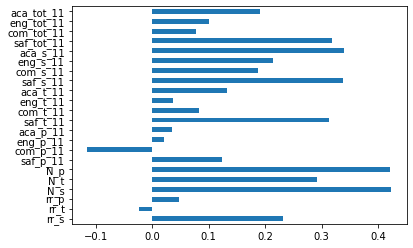

In [19]:
combined.corr().loc[survey_fields,'sat_score'].plot(kind='barh')

Nothing here is particularly surprising. A couple things worth noting might be that:
* In general, the number of survey respondents correlates positively with the sat scores.
* In general, the safety scores (as perceived by teachers and students) correlates positively with sat scores.

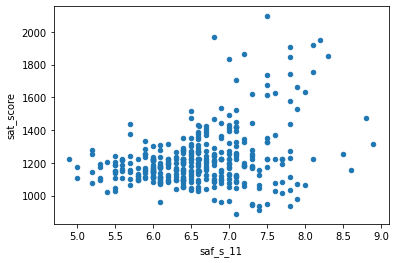

In [20]:
combined.plot('saf_s_11','sat_score',kind='scatter')
plt.show()

Plotting confirms that there does seem to be some kind of correlation between safety perception and SAT scores.

In [38]:
combined.groupby('boro').mean()['saf_s_11']

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64

Looks like Manhattan and Brooklyn have the two highest safety scores, per student survey respondents

<AxesSubplot:>

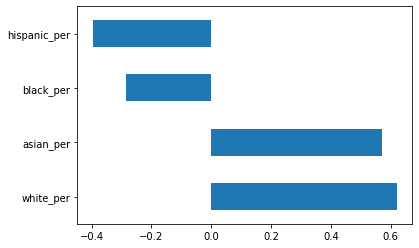

In [39]:
dem_cols = ['white_per','asian_per','black_per','hispanic_per']
combined.corr().loc[dem_cols,'sat_score'].plot(kind='barh')

This plot above seems to indicate that there is a positive correlation between the percentage of white and asian people in a high school and its SAT scores, but a negative correlation between the percentage of black and hispanic people in a high school and its SAT scores. This indicates that the SAT might not be the most fair test for all people groups

<AxesSubplot:xlabel='hispanic_per', ylabel='sat_score'>

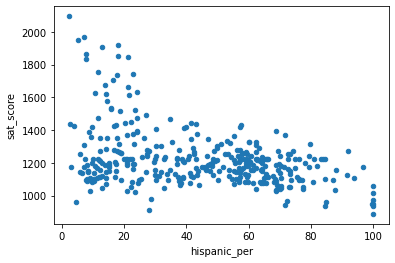

In [40]:
combined.plot('hispanic_per','sat_score',kind='scatter')

This plot confirms the findings from the bar plot above. The higher the percentage of hispanic students, the lower the sat score of the high school.

In [42]:
combined.loc[combined['hispanic_per']>95, 'SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Looking these schools up on Google/Wikipedia, we notice that a lot of them are geared towards spanish-speaking immigrants. We already know there's a strong negative correlation between the `ell_percent` (english learners/non-native english speakers) of a school and its sat scores. Sounds like the SAT is just not a fair test for non-english native speakers.

In [43]:
 combined.loc[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800),'SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Seems like the high schools with higher SAT score and lower hispanic percentage are technical schools, which would of course tend to have higher SAT scores. In other words, their SAT scores are higher likely because they tend to be more technically challenging schools, however they just tend to have fewer hispanic students.

<AxesSubplot:>

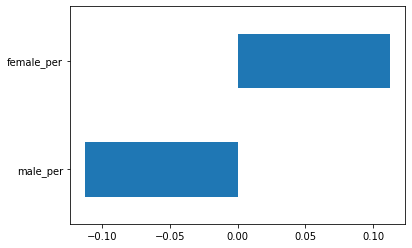

In [45]:
cols_to_inv = ['male_per','female_per']
combined.corr().loc[cols_to_inv,'sat_score'].plot(kind='barh')

Overall there is a loose correlation between gender breakdown and SAT scores.

<AxesSubplot:xlabel='female_per', ylabel='sat_score'>

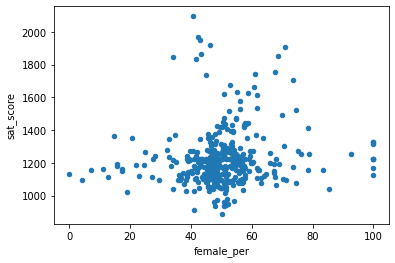

In [46]:
combined.plot('female_per','sat_score',kind='scatter')

As suspected there is no noteworthy correlation between female percentage of student body and sat scores.

In [48]:
combined.loc[(combined['female_per']>60) & (combined['sat_score'] > 1700),'SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Looking up these schools on Google yielded no noteworthy common attribute.

<AxesSubplot:xlabel='ap_per', ylabel='sat_score'>

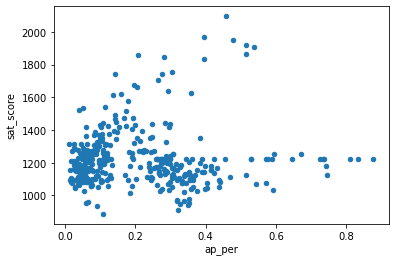

In [49]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined.plot('ap_per','sat_score',kind='scatter')

In [50]:
combined.corr().loc['ap_per','sat_score']

0.05717081390766952

The scatter plot and the correlation score indicate that there is actually no correlation between the percentage of a student body that takes at least one AP exam, with the school's SAT scores.